# Performance tests

* [This Coral TPU project](https://github.com/foobar167/junkyard/tree/master/coral_tpu)

Useful links:
* [TensorFlow models on the Edge TPU](https://coral.ai/docs/edgetpu/models-intro/#compatibility-overview)
* [Colab tutorials for Coral](https://github.com/google-coral/tutorials)
* [Retrain MobileNet V2 classifier for the Edge TPU (TF2)](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb)

## Helper functions

In [1]:
import os
import math
import json
import shutil
import zipfile
import tarfile
import platform

from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt


def extract(fname):
    """ Extract data from archive file """
    if fname.endswith(".tar.gz") or fname.endswith(".tgz"):
        ref = tarfile.open(fname, mode="r:gz")
    elif fname.endswith(".tar"):
        ref = tarfile.open(fname, mode="r:")
    elif fname.endswith(".tar.bz2") or fname.endswith(".tbz"):
        ref = tarfile.open(fname, mode="r:bz2")
    elif fname.endswith(".zip"):
        ref = zipfile.ZipFile(fname, mode="r")
    ref.extractall()
    ref.close()


def tgz(sdir):
    """ Make *.tgz archive file from source dir """
    sdir = sdir.strip("\\/")  # remove all leading and trailing slashes
    fname = os.path.basename(sdir)
    fname_tgz = fname + ".tgz"
    fname_tar_gz = fname + ".tar.gz"
    archive1 = os.path.join(os.path.dirname(sdir), fname_tgz)
    archive2 = os.path.join(os.path.dirname(sdir), fname_tar_gz)
    # Delete dir or file if exists
    if os.path.exists(archive1) and os.path.isdir(archive1):
        shutil.rmtree(archive1, ignore_errors=False)
    elif os.path.exists(archive1) and os.path.isfile(archive1):
        os.remove(archive1)
    # Make *.tag.gz file
    with tarfile.open(fname_tar_gz, "w:gz") as tar:
        tar.add(sdir, arcname=fname)
    # Reaneme *.tar.gz to *.tgz
    os.rename(archive2, archive1)


EXT = (".jpg", ".jpeg", ".png", ".gif")  # valid image file extensions


def separator(info=""):
    """ Separator string with information """
    sep1 = "-"
    sep2 = " "
    sep_length = 70  # separator length
    l1 = (sep_length - len(info)) // 2 - len(sep2)  # number of dashes
    if len(info) == 0:
        s = sep1 * sep_length
        return f"{s}"
    elif l1 <= 0:
        return info
    else:
        l2 = (sep_length - len(info)) % 2  # 0 or 1 extra space
        s1 = sep1 * l1
        s2 = info + " " * l2
        return f"{s1}{sep2}{s2}{sep2}{s1}"


def get_image_names(path):
    """ Get all image names in a directory """
    names = []
    for f in os.listdir(path):
        if f.lower().endswith(EXT):
            names.append(f)
    return names


def get_image_names2(path):
    """ Get all image names in a directory and
        return the list of (label, name) """
    dataset = []  # list of (label, name)
    classes = {}  # dict of classes
    for root, dirs, files in os.walk(path, topdown=True):
        for name in files:
            if name.lower().endswith(EXT):
                label = os.path.basename(root)
                name = os.path.join(root, name)
                dataset.append((int(label), name))
                classes[label] = label
    return dataset, classes


def get_images(path):
    """ Get all images in a directory """
    images = {}
    for f in os.listdir(path):
        if f.lower().endswith(EXT):
            images[f] = Image.open(os.path.join(path, f)).convert("RGB")
    return images


def get_images2(lst):
    """ Get all images from the list (label, name) and
        return dictoonary of images """
    images = {}
    for label, name in lst:
        if name.lower().endswith(EXT):
            images[name] = Image.open(name).convert("RGB")
    return images


def show2(images, cmap="viridis"):
    """ Show images with matplotlib. Default color map is "viridis" """
    for key, value in images.items():
        value = value.resize((100, 100))
        display(value)


def show(images, cmap="viridis"):
    """ Show images with matplotlib. Default color map is "viridis" """
    fig = plt.figure(figsize=(12, 8))  # create figure
    l = len(images)
    rows = math.floor(math.sqrt(l))
    cols = math.ceil(l / rows)
    for i, (key, value) in enumerate(images.items(), 1):
        fig.add_subplot(rows, cols, i)  # add a subplot
        plt.imshow(value, cmap=cmap); plt.axis("off"); plt.title(key)
    plt.show()


def load_labels(idx=1):
    """ Get ImageNet dataset labels from URL """
    url = "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/data/imagenet_class_index.json"
    name = os.path.basename(url)
    if not os.path.exists(name):
        output = os.system(f"wget {url} -O {name}")
        if output != 0:
            print(f"Error when downloading URL: {url}")
            return None
    CLASS_INDEX = json.load(open(name))
    labels = []
    for i in range(len(CLASS_INDEX)):
        # CLASS_INDEX example: "753": ["n04040759", "radiator"]
        labels.append(CLASS_INDEX[str(i)][idx])
    return labels


_INFO = {
    "Linux": "lscpu | grep 'Model name:'",
    "Windows": "wmic cpu get name, numberofcores",
}[platform.system()]


print(separator("CPU info"))
print(os.popen(cmd=_INFO).read())  # get info about the hardware (CPU)

------------------------------ CPU info ------------------------------
Name                                      NumberOfCores  

Intel(R) Core(TM) i5-2410M CPU @ 2.30GHz  2              






## Classify with different models

Take different neural network architectures for [ImageNet](https://www.image-net.org/) from TF repository: [Module: tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications)


cat.jpg
human.jpg
panda.jpg
parrot.jpg


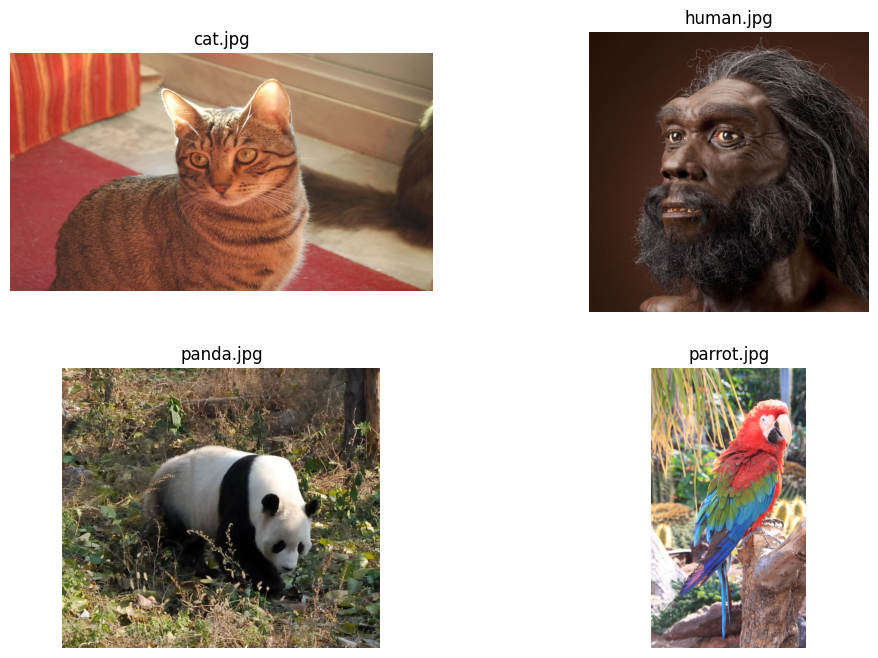

In [2]:
# Import necessary libraries
import time
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.applications as apps

from IPython.display import display
# from tensorflow.keras.saving import save_model, load_model
from tensorflow.keras.models import save_model, load_model


# Create "temp" directory and make it the current dir
TEMP_DIR = "temp"
THIS_DIR = os.path.dirname(os.path.realpath("__file__"))  # path to the current dir
if os.path.basename(THIS_DIR) == TEMP_DIR:  # already in the "temp" directory
    pass
else:
    os.makedirs(TEMP_DIR, exist_ok=True)
    os.chdir(os.path.join(THIS_DIR, TEMP_DIR))  # make path to "temp" dir the current path


# Download test images and show them
urls = {"parrot.jpg": "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/parrot.jpg",
        "cat.jpg":    "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/cat.jpg",
        "panda.jpg":  "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/panda.jpg",
        "human.jpg":  "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/pictures/human.jpg",
}
img_paths = []
for name, url in urls.items():
    if os.path.exists(name):
        continue
    output = os.system(f"wget {url} -O {name}")
    if output == 0:
        img_paths.append(name)
    else:
        print(f"Error when downloading URL: {url}")
print("\n".join(get_image_names(".")))  # print image names
show(get_images("."))  # show images


# Set constants
BATCH_SIZE = 100
IMAGE_SHAPE = (224, 224, 3)  # do not change it
IMAGE_SHAPE2 = (299, 299, 3)  # do not change it
RESIZE_METHOD = Image.BILINEAR
# RESIZE_METHOD2 = tf.image.ResizeMethod.BILINEAR
RESIZE_METHOD2 = tf.compat.v1.image.ResizeMethod.BILINEAR
BENCHMARK_IMG = "parrot.jpg"
COUNT = 12  # number of runs for benchmark
TOP_K = 3  # get first top results
OPTIMIZER = "rmsprop"
LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
METRICS = ["accuracy"]
IMAGENETV2_PATH = "imagenetv2-matched-frequency-format-val"  # path to ImageNet-v2 dataset
IMAGENETV2_SMALL = "imagenetv2-small"  # path to small dataset based on ImageNet-v2


# Models dictionary in the format: key: [name, "", norm, shape]
net = {
    "MobileNetV2": ["mobilenetv2_1.0_224",  # v[0] model filename
                    "placeholder",          # v[1] placeholder for variables
                    True,                   # v[2] normalize image or not
                    IMAGE_SHAPE],           # v[3] input image shape
    "MobileNetV3LargeMin": ["mobilenetv3large_1.0_224", "placeholder", True, IMAGE_SHAPE],
    "MobileNetV3SmallMin": ["mobilenetv3small_1.0_224", "placeholder", True, IMAGE_SHAPE],
    "DenseNet121": ["densenet121_224", "placeholder", True, IMAGE_SHAPE],
    "InceptionV3": ["inceptionv3_299", "placeholder", True, IMAGE_SHAPE2],
    "ResNet50": ["resnet50_224", "placeholder", False, IMAGE_SHAPE],    # norm==False, check it for diff. TF
    "ResNet101": ["resnet101_224", "placeholder", False, IMAGE_SHAPE],  # norm==False, check it for diff. TF
    "ResNet50V2": ["resnet50v2_224", "placeholder", True, IMAGE_SHAPE],
    "ResNet101V2": ["resnet101v2_224", "placeholder", True, IMAGE_SHAPE],
    "Xception": ["xception_299", "placeholder", True, IMAGE_SHAPE2],
    "VGG16": ["vgg16_224", "placeholder", False, IMAGE_SHAPE],  # norm==False, check it for diff. TF
}

## Unzip and prepare archive with models
Unzip and prepare archive with models from the previous step called
"[Get data for tests](https://colab.research.google.com/drive/1YLFMUxzHETAuOK69X_YQ_ei913W5cTMo)".

File "all_files.zip" should be in the "data" subfolder.
Change path to your archive with model files if necessary.

In [4]:
%%script echo "Skip this cell"

extract("../data/all_files.zip")  # extract from "*.zip" archive

Skip this cell


### Model size

| Model name          | TF, MB | f32, MB | f16, MB | dyn, MB | uint8, MB | coral, MB |
| ------------------- | ------ | ------- | ------- | ------- | --------- | --------- |
| MobileNetV2         |   16.4 |    13.3 |     6.7 |     3.6 |       3.8 |       4.1 |
| MobileNetV3LargeMin |   17.8 |    15.0 |     7.5 |     4.0 |       4.1 |       4.4 |
| MobileNetV3SmallMin |    9.9 |     7.8 |     3.9 |     2.1 |       2.2 |       2.4 |
| DenseNet121         |   37.9 |    30.5 |    15.3 |     9.1 |       8.0 |       9.3 |
| InceptionV3         |   96.0 |    90.9 |    45.5 |    23.0 |      23.2 |      24.0 |
| ResNet50            |  101.1 |    97.4 |    48.7 |    24.8 |      25.1 |      24.9 |
| ResNet101           |  177.0 |   169.8 |    85.0 |    43.3 |      43.9 |      43.4 |
| ResNet50V2          |  100.9 |    97.6 |    48.8 |    26.9 |      25.1 |      25.4 |
| ResNet101V2         |  176.7 |   170.1 |    85.1 |    43.6 |      43.9 |      44.4 |
| Xception            |   90.0 |    87.1 |    43.6 |    22.5 |      23.1 |      24.2 |
| VGG16               |  528.1 |   527.8 |   263.9 |   132.0 |     132.1 |     132.3 |


In [25]:
from pathlib import Path


def get_folder_size(folder):
    return ByteSize(sum(file.stat().st_size for file in Path(folder).rglob('*')))


class ByteSize(int):

    _KB = 1024
    _suffixes = 'B', 'KB', 'MB', 'GB', 'PB'

    def __new__(cls, *args, **kwargs):
        return super().__new__(cls, *args, **kwargs)

    def __init__(self, *args, **kwargs):
        self.bytes = self.B = int(self)
        self.kilobytes = self.KB = self / self._KB**1
        self.megabytes = self.MB = self / self._KB**2
        self.gigabytes = self.GB = self / self._KB**3
        self.petabytes = self.PB = self / self._KB**4
        *suffixes, last = self._suffixes
        suffix = next((
            suffix
            for suffix in suffixes
            if 1 < getattr(self, suffix) < self._KB
        ), last)
        self.readable = suffix, getattr(self, suffix)

        super().__init__()

    def __str__(self):
        return self.__format__('.1f')

    def __repr__(self):
        return '{}({})'.format(self.__class__.__name__, super().__repr__())

    def __format__(self, format_spec):
        suffix, val = self.readable
        return '{val:{fmt}} {suf}'.format(val=val, fmt=format_spec, suf=suffix)

    def __sub__(self, other):
        return self.__class__(super().__sub__(other))

    def __add__(self, other):
        return self.__class__(super().__add__(other))
    
    def __mul__(self, other):
        return self.__class__(super().__mul__(other))

    def __rsub__(self, other):
        return self.__class__(super().__sub__(other))

    def __radd__(self, other):
        return self.__class__(super().__add__(other))
    
    def __rmul__(self, other):
        return self.__class__(super().__rmul__(other))


# Get model size
for k, v in net.items():
    print(f"\n{separator(v[0])}\n")
    print("TF:", get_folder_size(v[0]))
    for e in [".tflite", "_float16.tflite", "_dynamic.tflite",
              "_int8.tflite", "_int8_edgetpu.tflite",]:
        fn = v[0] + e
        fp = os.path.join(TEMP_DIR, fn)
        size = os.path.getsize(fp) / 1024**2  # file size in MB
        print(f"{fn}: {size:.1f} MB")


------------------------ mobilenetv2_1.0_224  ------------------------

TF: 16.4 MB
mobilenetv2_1.0_224.tflite: 13.3 MB
mobilenetv2_1.0_224_float16.tflite: 6.7 MB
mobilenetv2_1.0_224_dynamic.tflite: 3.6 MB
mobilenetv2_1.0_224_int8.tflite: 3.8 MB
mobilenetv2_1.0_224_int8_edgetpu.tflite: 4.1 MB

---------------------- mobilenetv3large_1.0_224 ----------------------

TF: 17.8 MB
mobilenetv3large_1.0_224.tflite: 15.0 MB
mobilenetv3large_1.0_224_float16.tflite: 7.5 MB
mobilenetv3large_1.0_224_dynamic.tflite: 4.0 MB
mobilenetv3large_1.0_224_int8.tflite: 4.1 MB
mobilenetv3large_1.0_224_int8_edgetpu.tflite: 4.4 MB

---------------------- mobilenetv3small_1.0_224 ----------------------

TF: 9.9 MB
mobilenetv3small_1.0_224.tflite: 7.8 MB
mobilenetv3small_1.0_224_float16.tflite: 3.9 MB
mobilenetv3small_1.0_224_dynamic.tflite: 2.1 MB
mobilenetv3small_1.0_224_int8.tflite: 2.2 MB
mobilenetv3small_1.0_224_int8_edgetpu.tflite: 2.4 MB

-------------------------- densenet121_224  ----------------------

## Run speed benchmarks for TF

In [4]:
def preprocess_input(img_path, normalize, im_shape):
    """ Preprocess input. Analogue of
        "tf.keras.applications.mobilenet_v*.preprocess_input" function """
    img = Image.open(img_path).resize(im_shape[0:2], RESIZE_METHOD)
    img = np.asarray(img)  # convert from PIL Image to NumPy
    if normalize:  # normalize image
        img = img / 127.5 - 1.0
    else:  # don't normalize image
        pass
    img = np.expand_dims(img, axis=0)  # (224,224,3) to (1,224,224,3)
    return img


def decode_predictions(results):
    """ Decode predictions. Analogue of
        "tf.keras.applications.mobilenet_v*.decode_predictions" function """
    labels = load_labels()
    top = results.argsort()[-TOP_K:][::-1]  # get first top k results
    # Return list of tuples (label, probability)
    return [(labels[i], f"{results[i]:.4f}") for i in top]


def average_runtime(runtime):
    """ Show average runtime """
    if len(runtime) > 5:
        runtime = runtime[2:]  # skip the first 2 values
    elif len(runtime) > 1:
        runtime = runtime[1:]  # skip the 1st value
    average = f"{np.average(runtime):>6.1f} ms"
    print(f"Average time of the last {len(runtime)} runs: {average}")
    return average


def run_unconverted(img_path, model_name, normalize, im_shape, unpack=True):
    """ Run unconverted TF model for image """
    path = os.path.join(TEMP_DIR, model_name)
    if unpack:
        extract(path + ".tgz")  # extract from "*.tgz" archive
    # Should be "compile=False" for different TF versions
    # model = tf.keras.layers.TFSMLayer(model_name, call_endpoint="serving_default")  # Keras3
    model = load_model(model_name, compile=False)  # not supported in Keras3
    # Set optimizer, loss and metrics for evaluation if necessary
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    print(separator("INFERENCE TIME"))
    img = preprocess_input(img_path, normalize, im_shape)  # preprocess image
    runtime = []
    for _ in range(COUNT):
        start_time = time.time()
        model(img, training=False)  # predict
        stop_time = time.time()
        runtime.append((stop_time - start_time) * 1000)
        print(f"{(runtime[-1]):.1f} ms")
    print(separator("RESULTS"))
    results = model(img, training=False)  # predict
    del model
    results = results.numpy()[0]  # convert from tf to numpy
    print(decode_predictions(results))
    return average_runtime(runtime)


def benchmark(img_path, run):
    """ Run benchmarks """
    for k, v in net.items():
        print(f"\n{separator(v[0])}\n")
        v[1] = run(img_path=img_path, model_name=v[0], normalize=v[2], im_shape=v[3])

    print(f"\n" f"Speeds for '{img_path}' image are:")
    for k, v in net.items():
        print(f"{k:12} {v[1]}")

In [ ]:
benchmark(BENCHMARK_IMG, run_unconverted)


------------------------ mobilenetv2_1.0_224  ------------------------

--------------------------- INFERENCE TIME ---------------------------
437.5 ms
183.5 ms


## Prepare the ImageNet-v2 dataset
Download and unarchivate the [ImageNet-v2](https://www.tensorflow.org/datasets/catalog/imagenet_v2)
dataset **manually** to make performance tests for CPU and TPU uniform.

In [ ]:
%%script echo "Skip this cell"

def create_small_dataset(path):
    """ Create smaller dataset from larger ImageNet-v2 """
    os.makedirs(IMAGENETV2_SMALL, exist_ok=True)  # create dir if necessary
    for root, dirs, files in os.walk(path, topdown=True):
        n = 1  # number of images to copy
        i = 0  # counter of copied images
        for name in files:
            if name.lower().endswith(EXT):
                label = os.path.basename(root)
                name = os.path.join(root, name)
                p = os.path.join(IMAGENETV2_SMALL, label)
                os.makedirs(p, exist_ok=True)
                shutil.copy2(name, p)
                i += 1
                if i == n:
                    break  # exit from the inner cycle


create_small_dataset(IMAGENETV2_PATH)

In [ ]:
# Prepare the ImageNet-v2 dataset manually without TF
DS, CLASSES = get_image_names2(IMAGENETV2_SMALL)

example = DS[:6]
print(*example, sep="\n")
imgs = get_images2(example)
show(imgs)  # visualize dataset images
print(f"Number of classes: {len(CLASSES)}")
print(f"Number of images: {len(DS)}")

## Run speed benchmarks for TF Lite

In [ ]:
def run_converted(img_path, model_name, normalize, im_shape, ext=".tflite"):
    """ Run converted TF Lite model for image """
    model_name += ext  # use "*.tflite" files
    print(model_name)

    interpreter = tf.lite.Interpreter(model_path=os.path.join(TEMP_DIR, model_name))
    interpreter.allocate_tensors()  # allocate memory for the model's input tensors

    # Use input and output details to get info about model parameters
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # # Visualize in/out details. Uncomment for debug purposes
    # print(f"\n" f"input_details:")
    # for k, v in input_details.items():
    #     print(f"{k} => {v}")
    # print(f"\n" f"output_details:")
    # for k, v in output_details.items():
    #     print(f"{k} => {v}")
    # print()

    height = input_details["shape"][1]  # NxHxWxC or [1, 224, 224, 3], H:1, W:2
    width = input_details["shape"][2]
    params = input_details["quantization_parameters"]
    scale, zero_point = params["scales"], params["zero_points"]
    norm, mean = 127.5, 127.5
    dtype = input_details["dtype"]  # float32 or int for quantized model

    # Image data must go through two transforms before running inference:
    #     1. normalization: f = (input - mean) / norm
    #     2. quantization: q = f / scale + zero_point
    # The following code combines the two steps as such:
    #     q = (input - mean) / (norm * scale) + zero_point
    #
    # However, if norm * scale equals 1, and mean - zero_point equals 0, the input
    #   does not need any preprocessing (but in practice, even if the results are
    #   very close to 1 and 0, it is probably okay to skip preprocessing for better
    #   efficiency; we use 1e-5 below instead of absolute zero).
    #
    # There are following options:
    #   | No. | Normalization | Quantization | Details          |
    #   | --- | ------------- | ------------ | ---------------- |
    #   | 1   | yes           | no           |                  |
    #   | 2   | no            | no           |                  |
    #   | 3   | no            | yes          |                  |
    #   | 4   | yes           | yes          | No preprocessing |
    #   | 5   | yes           | yes          |                  |
    img = Image.open(img_path).resize((width, height), RESIZE_METHOD)
    # 1. Normalization - yes. Quantization - no.
    if normalize and (scale.size == 0 or zero_point.size == 0):
        print("- 1 -")
        img = (np.asarray(img) - mean) / norm
    # 2. Normalization - no. Quantization - no.
    elif (not normalize) and (scale.size == 0 or zero_point.size == 0):
        print("- 2 -")
        pass
    # 3. Normalization - no. Quantization - yes.
    elif (not normalize):
        print("- 3 -")
        img = np.asarray(img) / scale + zero_point
    # 4. Norm - yes. Quant - yes. No preprocessing.
    elif abs(scale * norm - 1) < 1e-5 and abs(int(mean) - zero_point) < 1e-5:
        print("- 4 -")
        pass
    # 5. Normalization - yes. Quantization - yes.
    else:
        print("- 5 -")
        img = (np.asarray(img) - mean) / (norm * scale) + zero_point
        np.clip(img, 0, 255, out=img)  # clip values to [0, 255]. Not sure if this is necessary

    img = np.asarray(img, dtype=dtype)  # convert to necessary type
    img = np.expand_dims(img, axis=0)  # [224, 224, 3] to [1, 224, 224, 3]
    interpreter.set_tensor(input_details["index"], img)

    print(separator("INFERENCE TIME"))
    runtime = []
    for _ in range(COUNT):
        start_time = time.time()
        interpreter.invoke()  # predict using TF Lite
        stop_time = time.time()
        runtime.append((stop_time - start_time) * 1000)
        print(f"{(runtime[-1]):.1f} ms")

    print(separator("RESULTS"))
    # interpreter.get_tensor() copies data, but interpreter.tensor() avoids copying data
    results = interpreter.tensor(output_details["index"])().flatten()

    # De-quantize, if necessary
    if output_details["quantization"][0] and \
       np.issubdtype(output_details["dtype"], np.integer):
        print(" - de-quantize -")
        # Usually scale == 1/256 and zero_point == 0
        scale, zero_point = output_details["quantization"]
        # Always convert to np.int64 to avoid overflow on subtraction.
        results = scale * (results.astype(np.int64) - zero_point)

    # Clear resources to prevent error: "Segmentation fault (core dumped)"
    del interpreter

    print(decode_predictions(results))
    return average_runtime(runtime)

### Run TF Lite without quantization

In [ ]:
# Run TF Lite without quantization
benchmark(BENCHMARK_IMG, run_converted)

### Run TF Lite with uint8 quantization

In [ ]:
# Run TF Lite with uint8 quantization
run_it = lambda img_path, model_name, normalize, im_shape: run_converted(img_path, model_name, normalize, im_shape, ext="_int8.tflite")
benchmark(BENCHMARK_IMG, run_it)

## Estimate accuracy and speed on ImageNet-v2 dataset

In [ ]:
def prepare(name, normalize, im_shape):
    """ Prepare datapoint (label, name) and return (label, image) tuple """
    # Open and resize the image
    img = Image.open(name).resize(im_shape[0:2], RESIZE_METHOD)
    img = np.float32(img)  # convert from uint8 to float32
    if normalize:  # normalize
        img = img / 127.5 - 1.0
    else:  # don't normalize
        pass
    return img


def evaluate(dataset, model_name, normalize, im_shape, ext):
    """ TFLite model evaluation function """
    model_name += ext  # use "*_int8_edgetpu.tflite" files
    print(ext)

    # calculate on CPU
    interpreter = tf.lite.Interpreter(model_path=os.path.join(TEMP_DIR, model_name))
    interpreter.allocate_tensors()  # allocate memory for the model's input tensors

    # Use input and output details to get info about model parameters
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # # Visualize in/out details. Uncomment for debug purposes
    # print(f"\n" f"input_details:")
    # for k, v in input_details.items():
    #     print(f"{k} => {v}")
    # print(f"\n" f"output_details:")
    # for k, v in output_details.items():
    #     print(f"{k} => {v}")
    # print()

    params = input_details["quantization_parameters"]
    scale, zero_point = params["scales"], params["zero_points"]
    dtype = input_details["dtype"]  # float32 or int for quantized model

    # De-quantization is not necessary, because took max value without accuracy
    quant = False  # quantization
    if scale.size == 0 or zero_point.size == 0:
        pass
    else:
        # print("quantization - yes")
        quant = True

    true_labels = []
    predictions = []
    total = len(dataset)
    start_time = time.time()

    # Process the dataset
    for i, (label, name) in enumerate(dataset):
        if i % 300 == 0:
            print(f"\r" f"Evaluated {i} from {total}",
                  f" in {(time.time() - start_time):.0f} sec", end="")

        img = prepare(name, normalize, im_shape)

        # Image can go through quantization before running inference:
        #     quantization: q = f / scale + zero_point
        if quant:
            img = img / scale + zero_point
            np.clip(img, 0, 255, out=img)  # clip values to [0, 255]

        img = np.array(img, dtype=dtype)  # convert to necessary type
        img = np.expand_dims(img, axis=0)  # [224, 224, 3] to [1, 224, 224, 3]
        interpreter.set_tensor(input_details["index"], img)
        interpreter.invoke()  # predict
        results = interpreter.tensor(output_details["index"])().flatten()
        i = np.argmax(results)
        predictions.append(i)
        true_labels.append(label)

    # Finish processing the dataset
    print("\r", end="")
    del interpreter
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = (predictions == true_labels).mean() * 100  # get accuracy in %
    runtime = time.time() - start_time  # runtime in seconds
    print(f"Accuracy: {accuracy:.1f} %; time: {runtime:.1f} sec {' '*40}" f"\n")


def evaluate_tf(dataset, model_path, normalize, im_shape):
    """ TF model evaluation function.
        Evaluate every image by hand. """
    print("tf")
    model = load_model(model_path)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    true_labels = []
    predictions = []
    total = len(dataset)
    start_time = time.time()

    # Process the dataset
    for i, (label, name) in enumerate(dataset):
        if i % 300 == 0:
            print(f"\r" f"Evaluated {i} from {total}",
                  f" in {(time.time() - start_time):.0f} sec", end="")
        img = prepare(name, normalize, im_shape)
        img = np.expand_dims(img, axis=0)  # [224, 224, 3] to [1, 224, 224, 3]
        results = model(img, training=False)  # predict
        results = results.numpy()[0]  # convert from tf to numpy
        i = np.argmax(results)
        predictions.append(i)
        true_labels.append(label)

    # Finish processing the dataset
    print("\r", end="")
    del model
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = (predictions == true_labels).mean() * 100  # get accuracy in %
    runtime = time.time() - start_time  # runtime in seconds
    print(f"Accuracy: {accuracy:.1f} %; time: {runtime:.1f} sec {' '*40}" f"\n")

### Run short preliminary tests

In [ ]:
def performance_tests(n):
    start_time = time.time()
    for k, v in net.items():
        print(separator(v[0]))
        evaluate_tf(DS[:n], v[0], v[2], v[3])
        for e in [".tflite", "_float16.tflite", "_dynamic.tflite", "_int8.tflite",]:
            evaluate(DS[:n], v[0], v[2], v[3], ext=e)
    stop_time = time.time()
    print(f"Runtime: {(stop_time - start_time):.0f} seconds")

In [ ]:
# Run short preliminary tests
performance_tests(30)

### Run on ImageNet-v2

Runtime for **1000** images:
* Runtime ≈ 4 hours (242 min) for CoolPi
* Runtime ≈ 15.4 hours (925 min) for Pi4

Accuracy and speed for **Cool Pi 4 Model B**

For **1000** images:
| Model name          | TF, % | TF, sec | f32, % | f32, sec | f16, % | f16, sec | dyn, % | dyn, sec | uint8, % | uint8, sec |
| ------------------- | ----- | ------- | ------ | -------- | ------ | -------- | ------ | -------- | -------- | ---------- |
| MobileNetV2         |  56.6 |   217.0 |   56.6 |     28.7 |   56.4 |     28.7 |   56.5 |     26.9 |     55.5 |       18.5 |
| MobileNetV3LargeMin |  55.4 |   159.6 |   55.4 |     21.7 |   55.4 |     21.7 |   55.3 |     20.1 |     49.5 |       15.4 |
| MobileNetV3SmallMin |  44.2 |    93.5 |   44.2 |     10.7 |   44.2 |     10.7 |   43.0 |     10.7 |     31.6 |        9.6 |
| DenseNet121         |  56.3 |   521.5 |   56.3 |    187.5 |   56.3 |    187.3 |   55.8 |    103.4 |     13.6 |       74.0 |
| InceptionV3         |  64.3 |   542.4 |   64.3 |    342.8 |   64.3 |    342.5 |   64.5 |    134.7 |     64.4 |      107.0 |
| ResNet50            |  35.9 |   425.4 |   35.9 |    245.9 |   35.6 |    245.3 |   35.4 |    101.3 |     35.7 |       77.1 |
| ResNet101           |  40.7 |   817.0 |   40.7 |    456.5 |   40.6 |    455.6 |   40.2 |    171.1 |     40.2 |      135.6 |
| ResNet50V2          |  55.6 |   404.8 |   55.6 |    229.9 |   55.6 |    228.7 |   54.8 |     96.8 |     55.5 |       79.2 |
| ResNet101V2         |  57.3 |   799.9 |   57.3 |    444.1 |   57.3 |    444.1 |   57.5 |    171.1 |     56.4 |      142.8 |
| Xception            |  66.4 |   551.4 |   66.4 |    508.7 |   66.5 |    510.2 |   66.1 |    229.8 |     15.5 |      186.0 |
| VGG16               |  31.9 |   490.3 |   31.9 |    976.2 |   31.9 |    974.2 |   31.9 |    307.2 |     32.3 |      246.0 |


For **10 000** images:
| Model name | TF acc, % | TF speed, sec | TFLite acc, % | TFLite speed, sec | uint8 acc, % | uint8 speed, sec |
| ---------- | --------- | ------------- | ------------- | ----------------- | ------------ | ---------------- |
| MobileNetV2      | 55.8 | 2026.1 | 55.8 | 298.7 | 55.1 | 188.8 |
| MobileNetV3Large | 58.5 | 2420.6 | 58.5 | 250.4 | 10.7 | 270.0 |
| MobileNetV3Small | 49.8 | 1675.3 | 49.8 | 128.8 | 22.5 | 117.1 |
| DenseNet121      | 56.5 | 5257.3 | 56.5 | 2020.5 | 7.9 | 759.3 |
| InceptionV3      | 63.8 | 5745.1 | 63.8 | 3569.1 | 63.7 | 1201.2 |
| ResNet50         | 34.9 | 4308.8 | 34.9 | 2589.1 | 0.1 | 791.1 |
| ResNet101        | 37.7 | 8241.0 | 37.7 | 4725.7 | 0.1 | 1495.8 |
| ResNet50V2       | 53.1 | 4108.0 |  |  |  |  |
| ResNet101V2      |  |  |  |  |  |  |
| VGG16            | - | - | - | - | - | - |
| Xception         |  |  |  |  |  |  |


Accuracy and speed for **Raspberry Pi 4 Model B**

For **1000** images:
| Model name          | TF, % | TF, sec | f32, % | f32, sec | f16, % | f16, sec | dyn, % | dyn, sec | uint8, % | uint8, sec |
| ------------------- | ----- | ------- | ------ | -------- | ------ | -------- | ------ | -------- | -------- | ---------- |
| MobileNetV2         |  56.6 |   559.2 |   56.6 |     92.4 |   56.4 |     92.3 |   56.5 |    101.0 |     55.5 |       65.6 |
| MobileNetV3LargeMin |  55.4 |   482.4 |   55.4 |     67.8 |   55.4 |     67.6 |   55.3 |     72.7 |     49.5 |       50.9 |
| MobileNetV3SmallMin |  44.2 |   314.2 |   44.2 |     29.2 |   44.2 |     27.7 |   43.0 |     29.2 |     31.6 |       26.8 |
| DenseNet121         |  56.3 |  1540.0 |   56.3 |    631.1 |   56.3 |    630.0 |   55.8 |    525.5 |     13.6 |      376.7 |
| InceptionV3         |  64.3 |  1450.7 |   64.3 |   1209.8 |   64.3 |   1206.3 |   64.5 |    747.5 |     64.4 |      624.8 |
| ResNet50            |  35.9 |  1009.5 |   35.9 |    911.0 |   35.6 |    928.2 |   35.4 |    550.4 |     35.7 |      474.8 |
| ResNet101           |  40.7 |  1967.6 |   40.7 |   1874.2 |   40.6 |   1862.1 |   40.2 |   1004.7 |     40.2 |      841.7 |
| ResNet50V2          |  55.6 |  1004.1 |   55.6 |    889.9 |   55.6 |    889.0 |   54.8 |    516.2 |     55.5 |      448.7 |
| ResNet101V2         |  57.3 |  1936.8 |   57.3 |   1838.5 |   57.3 |   1850.7 |   57.5 |    976.5 |     56.4 |      822.5 |
| Xception            |  66.4 |  1401.4 |   66.4 |   2212.0 |   66.5 |   2216.6 |   66.1 |   1158.2 |     15.5 |      953.1 |
| VGG16               |  31.9 |  1462.9 |   31.9 |   3854.5 |   31.9 |   3855.9 |   31.9 |   1807.0 |     32.3 |     1760.1 |


For **10 000** images:
| Model name | TF acc, % | TF speed, sec | TFLite acc, % | TFLite speed, sec | uint8 acc, % | uint8 speed, sec |
| ---------- | --------- | ------------- | ------------- | ----------------- | ------------ | ---------------- |
| MobileNetV2      | 55.8 | 5231.6 | 55.8 | 939.9 | 55.1 | 699.6 |
| MobileNetV3Large | 58.5 | 7670.1 | 58.5 | 802.8 | 10.7 | 867.7 |
| MobileNetV3Small | 49.8 | 6096.1 | 49.8 | 369.4 | 22.5 | 340.6 |
| DenseNet121      |  |  |  |  |  |  |
| InceptionV3      |  |  |  |  |  |  |
| ResNet50         |  |  |  |  |  |  |
| ResNet101        |  |  |  |  |  |  |
| ResNet50V2       |  |  |  |  |  |  |
| ResNet101V2      |  |  |  |  |  |  |
| VGG16            | - | - | - | - | - | - |
| Xception         |  |  |  |  |  |  |

**Note**: VGG16 demands several GB RAM. Too much for CoolPi and Pi4 3.4--3.6 GB. Run VGG16 separately.

In [ ]:
# %%script echo "Skip this cell."

# Run on ImageNet-v2 10000 images
performance_tests(len(DS))

### Log data for Cool Pi 4 Model B **1k images**

    ------------------------ mobilenetv2_1.0_224  ------------------------
    tf
    Accuracy: 56.6 %; time: 217.0 sec                                         
    
    .tflite
    Accuracy: 56.6 %; time: 28.7 sec                                         
    
    _float16.tflite
    Accuracy: 56.4 %; time: 28.7 sec                                         
    
    _dynamic.tflite
    Accuracy: 56.5 %; time: 26.9 sec                                         
    
    _int8.tflite
    Accuracy: 55.5 %; time: 18.5 sec                                         
    
    ---------------------- mobilenetv3large_1.0_224 ----------------------
    tf
    Accuracy: 55.4 %; time: 159.6 sec                                         
    
    .tflite
    Accuracy: 55.4 %; time: 21.7 sec                                         
    
    _float16.tflite
    Accuracy: 55.4 %; time: 21.7 sec                                         
    
    _dynamic.tflite
    Accuracy: 55.3 %; time: 20.1 sec                                         
    
    _int8.tflite
    Accuracy: 49.5 %; time: 15.4 sec                                         
    
    ---------------------- mobilenetv3small_1.0_224 ----------------------
    tf
    Accuracy: 44.2 %; time: 93.5 sec                                         
    
    .tflite
    Accuracy: 44.2 %; time: 10.7 sec                                         
    
    _float16.tflite
    Accuracy: 44.2 %; time: 10.7 sec                                         
    
    _dynamic.tflite
    Accuracy: 43.0 %; time: 10.7 sec                                         
    
    _int8.tflite
    Accuracy: 31.6 %; time: 9.6 sec                                         
    
    -------------------------- densenet121_224  --------------------------
    tf
    Accuracy: 56.3 %; time: 521.5 sec                                         
    
    .tflite
    Accuracy: 56.3 %; time: 187.5 sec                                         
    
    _float16.tflite
    Accuracy: 56.3 %; time: 187.3 sec                                         
    
    _dynamic.tflite
    Accuracy: 55.8 %; time: 103.4 sec                                         
    
    _int8.tflite
    Accuracy: 13.6 %; time: 74.0 sec                                         
    
    -------------------------- inceptionv3_299  --------------------------
    tf
    Accuracy: 64.3 %; time: 542.4 sec                                         
    
    .tflite
    Accuracy: 64.3 %; time: 342.8 sec                                         
    
    _float16.tflite
    Accuracy: 64.3 %; time: 342.5 sec                                         
    
    _dynamic.tflite
    Accuracy: 64.5 %; time: 134.7 sec                                         
    
    _int8.tflite
    Accuracy: 64.4 %; time: 107.0 sec                                         
    
    ---------------------------- resnet50_224 ----------------------------
    tf
    Accuracy: 35.9 %; time: 425.4 sec                                         
    
    .tflite
    Accuracy: 35.9 %; time: 245.9 sec                                         
    
    _float16.tflite
    Accuracy: 35.6 %; time: 245.3 sec                                         
    
    _dynamic.tflite
    Accuracy: 35.4 %; time: 101.3 sec                                         
    
    _int8.tflite
    Accuracy: 35.7 %; time: 77.1 sec                                         
    
    --------------------------- resnet101_224  ---------------------------
    tf
    Accuracy: 40.7 %; time: 817.0 sec                                         
    
    .tflite
    Accuracy: 40.7 %; time: 456.5 sec                                         
    
    _float16.tflite
    Accuracy: 40.6 %; time: 455.6 sec                                         
    
    _dynamic.tflite
    Accuracy: 40.2 %; time: 171.1 sec                                         
    
    _int8.tflite
    Accuracy: 40.2 %; time: 135.6 sec                                         
    
    --------------------------- resnet50v2_224 ---------------------------
    tf
    Accuracy: 55.6 %; time: 404.8 sec                                         
    
    .tflite
    Accuracy: 55.6 %; time: 229.9 sec                                         
    
    _float16.tflite
    Accuracy: 55.6 %; time: 228.7 sec                                         
    
    _dynamic.tflite
    Accuracy: 54.8 %; time: 96.8 sec                                         
    
    _int8.tflite
    Accuracy: 55.5 %; time: 79.2 sec                                         
    
    -------------------------- resnet101v2_224  --------------------------
    tf
    Accuracy: 57.3 %; time: 799.9 sec                                         
    
    .tflite
    Accuracy: 57.3 %; time: 444.1 sec                                         
    
    _float16.tflite
    Accuracy: 57.3 %; time: 444.1 sec                                         
    
    _dynamic.tflite
    Accuracy: 57.5 %; time: 171.1 sec                                         
    
    _int8.tflite
    Accuracy: 56.4 %; time: 142.8 sec                                         
    
    ---------------------------- xception_299 ----------------------------
    tf
    Accuracy: 66.4 %; time: 551.4 sec                                         
    
    .tflite
    Accuracy: 66.4 %; time: 508.7 sec                                         
    
    _float16.tflite
    Accuracy: 66.5 %; time: 510.2 sec                                         
    
    _dynamic.tflite
    Accuracy: 66.1 %; time: 229.8 sec                                         
    
    _int8.tflite
    Accuracy: 15.5 %; time: 186.0 sec                                         
    
    Runtime: 11522 seconds

    ----------------------------- vgg16_224  -----------------------------
    tf
    
    2024-04-25 18:28:44.257695: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
    2024-04-25 18:28:44.430983: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
    2024-04-25 18:28:44.512468: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
    2024-04-25 18:28:45.423364: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
    
    Accuracy: 31.9 %; time: 490.3 sec                                         
    
    .tflite
    
    INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
    
    Accuracy: 31.9 %; time: 976.2 sec                                         
    
    _float16.tflite
    Accuracy: 31.9 %; time: 974.2 sec                                         
    
    _dynamic.tflite
    Accuracy: 31.9 %; time: 307.2 sec                                         
    
    _int8.tflite
    Accuracy: 32.3 %; time: 246.0 sec                                         
    
    Runtime: 3008 seconds


### Log data for Cool Pi 4 Model B **10k images**

    ------------------------ mobilenetv2_1.0_224  ------------------------
    tf
    Accuracy: 55.8 %; time: 2026.1 sec                                         
    
    .tflite
    Evaluated 0 from 10000  in 0 sec
    
    INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
    
    Accuracy: 55.8 %; time: 298.7 sec                                         
    
    _int8.tflite
    Accuracy: 55.1 %; time: 188.8 sec                                         
    
    ---------------------- mobilenetv3large_1.0_224 ----------------------
    tf
    Accuracy: 58.5 %; time: 2420.6 sec                                         
    
    .tflite
    Accuracy: 58.5 %; time: 250.4 sec                                         
    
    _int8.tflite
    Accuracy: 10.7 %; time: 270.0 sec                                         
    
    ---------------------- mobilenetv3small_1.0_224 ----------------------
    tf
    Accuracy: 49.8 %; time: 1675.3 sec                                         
    
    .tflite
    Accuracy: 49.8 %; time: 128.8 sec                                         
    
    _int8.tflite
    Accuracy: 22.5 %; time: 117.1 sec                                         
    
    -------------------------- densenet121_224  --------------------------
    tf
    Accuracy: 56.5 %; time: 5257.3 sec                                         
    
    .tflite
    Accuracy: 56.5 %; time: 2020.5 sec                                         
    
    _int8.tflite
    Accuracy: 7.9 %; time: 759.3 sec                                         
    
    -------------------------- inceptionv3_299  --------------------------
    tf
    Accuracy: 63.8 %; time: 5745.1 sec                                         
    
    .tflite
    Accuracy: 63.8 %; time: 3569.1 sec                                         
    
    _int8.tflite
    Accuracy: 63.7 %; time: 1201.2 sec                                         
    
    ---------------------------- resnet50_224 ----------------------------
    tf
    Accuracy: 34.9 %; time: 4308.8 sec                                         
    
    .tflite
    Accuracy: 34.9 %; time: 2589.1 sec                                         
    
    _int8.tflite
    Accuracy: 0.1 %; time: 791.1 sec                                         
    
    --------------------------- resnet101_224  ---------------------------
    tf
    Accuracy: 37.7 %; time: 8241.0 sec                                         
    
    .tflite
    Accuracy: 37.7 %; time: 4725.7 sec                                         
    
    _int8.tflite
    Accuracy: 0.1 %; time: 1495.8 sec                                         
    
    --------------------------- resnet50v2_224 ---------------------------
    tf
    Accuracy: 53.1 %; time: 4108.0 sec                                         
    
    .tflite
    Evaluated 3300 from 10000  in 805 sec

### Log data for Raspberry Pi 4 Model B **1k images**

    ------------------------ mobilenetv2_1.0_224  ------------------------
    tf
    Accuracy: 56.6 %; time: 559.2 sec                                         
    
    .tflite
    Accuracy: 56.6 %; time: 92.4 sec                                         
    
    _float16.tflite
    Accuracy: 56.4 %; time: 92.3 sec                                         
    
    _dynamic.tflite
    Accuracy: 56.5 %; time: 101.0 sec                                         
    
    _int8.tflite
    Accuracy: 55.5 %; time: 65.6 sec                                         
    
    ---------------------- mobilenetv3large_1.0_224 ----------------------
    tf
    Accuracy: 55.4 %; time: 482.4 sec                                         
    
    .tflite
    Accuracy: 55.4 %; time: 67.8 sec                                         
    
    _float16.tflite
    Accuracy: 55.4 %; time: 67.6 sec                                         
    
    _dynamic.tflite
    Accuracy: 55.3 %; time: 72.7 sec                                         
    
    _int8.tflite
    Accuracy: 49.5 %; time: 50.9 sec                                         
    
    ---------------------- mobilenetv3small_1.0_224 ----------------------
    tf
    Accuracy: 44.2 %; time: 314.2 sec                                         
    
    .tflite
    Accuracy: 44.2 %; time: 29.2 sec                                         
    
    _float16.tflite
    Accuracy: 44.2 %; time: 27.7 sec                                         
    
    _dynamic.tflite
    Accuracy: 43.0 %; time: 29.2 sec                                         
    
    _int8.tflite
    Accuracy: 31.6 %; time: 26.8 sec                                         
    
    -------------------------- densenet121_224  --------------------------
    tf
    Accuracy: 56.3 %; time: 1540.0 sec                                         
    
    .tflite
    Accuracy: 56.3 %; time: 631.1 sec                                         
    
    _float16.tflite
    Accuracy: 56.3 %; time: 630.0 sec                                         
    
    _dynamic.tflite
    Accuracy: 55.8 %; time: 525.5 sec                                         
    
    _int8.tflite
    Accuracy: 13.6 %; time: 376.7 sec                                         
    
    -------------------------- inceptionv3_299  --------------------------
    tf
    Accuracy: 64.3 %; time: 1450.7 sec                                         
    
    .tflite
    Accuracy: 64.3 %; time: 1209.8 sec                                         
    
    _float16.tflite
    Accuracy: 64.3 %; time: 1206.3 sec                                         
    
    _dynamic.tflite
    Accuracy: 64.5 %; time: 747.5 sec                                         
    
    _int8.tflite
    Accuracy: 64.4 %; time: 624.8 sec                                         
    
    ---------------------------- resnet50_224 ----------------------------
    tf
    Accuracy: 35.9 %; time: 1009.5 sec                                         
    
    .tflite
    Accuracy: 35.9 %; time: 911.0 sec                                         
    
    _float16.tflite
    Accuracy: 35.6 %; time: 928.2 sec                                         
    
    _dynamic.tflite
    Accuracy: 35.4 %; time: 550.4 sec                                         
    
    _int8.tflite
    Accuracy: 35.7 %; time: 474.8 sec                                         
    
    --------------------------- resnet101_224  ---------------------------
    tf
    Accuracy: 40.7 %; time: 1967.6 sec                                         
    
    .tflite
    Accuracy: 40.7 %; time: 1874.2 sec                                         
    
    _float16.tflite
    Accuracy: 40.6 %; time: 1862.1 sec                                         
    
    _dynamic.tflite
    Accuracy: 40.2 %; time: 1004.7 sec                                         
    
    _int8.tflite
    Accuracy: 40.2 %; time: 841.7 sec                                         
    
    --------------------------- resnet50v2_224 ---------------------------
    tf
    Accuracy: 55.6 %; time: 1004.1 sec                                         
    
    .tflite
    Accuracy: 55.6 %; time: 889.9 sec                                         
    
    _float16.tflite
    Accuracy: 55.6 %; time: 889.0 sec                                         
    
    _dynamic.tflite
    Accuracy: 54.8 %; time: 516.2 sec                                         
    
    _int8.tflite
    Accuracy: 55.5 %; time: 448.7 sec                                         
    
    -------------------------- resnet101v2_224  --------------------------
    tf
    Accuracy: 57.3 %; time: 1936.8 sec                                         
    
    .tflite
    Accuracy: 57.3 %; time: 1838.5 sec                                         
    
    _float16.tflite
    Accuracy: 57.3 %; time: 1850.7 sec                                         
    
    _dynamic.tflite
    Accuracy: 57.5 %; time: 976.5 sec                                         
    
    _int8.tflite
    Accuracy: 56.4 %; time: 822.5 sec                                         
    
    ---------------------------- xception_299 ----------------------------
    tf
    Accuracy: 66.4 %; time: 1401.4 sec                                         
    
    .tflite
    Accuracy: 66.4 %; time: 2212.0 sec                                         
    
    _float16.tflite
    Accuracy: 66.5 %; time: 2216.6 sec                                         
    
    _dynamic.tflite
    Accuracy: 66.1 %; time: 1158.2 sec                                         
    
    _int8.tflite
    Accuracy: 15.5 %; time: 953.1 sec            

    ----------------------------- vgg16_224  -----------------------------
    tf
    Accuracy: 31.9 %; time: 1462.9 sec                                         
    
    .tflite
    Accuracy: 31.9 %; time: 3854.5 sec                                         
    
    _float16.tflite
    Accuracy: 31.9 %; time: 3855.9 sec                                         
    
    _dynamic.tflite
    Accuracy: 31.9 %; time: 1807.0 sec                                         
    
    _int8.tflite
    Accuracy: 32.3 %; time: 1760.1 sec                                         
    
    Runtime: 12795 seconds

### Log data for Raspberry Pi 4 Model B **10k images**

    ------------------------ mobilenetv2_1.0_224  ------------------------
    tf
    Accuracy: 55.8 %; time: 5231.6 sec                                         
    
    .tflite
    Accuracy: 55.8 %; time: 939.9 sec                                         
    
    _int8.tflite
    Accuracy: 55.1 %; time: 699.6 sec                                         
    
    ---------------------- mobilenetv3large_1.0_224 ----------------------
    tf
    Accuracy: 58.5 %; time: 7670.1 sec                                         
    
    .tflite
    Accuracy: 58.5 %; time: 802.8 sec                                         
    
    _int8.tflite
    Accuracy: 10.7 %; time: 867.7 sec                                         
    
    ---------------------- mobilenetv3small_1.0_224 ----------------------
    tf
    Accuracy: 49.8 %; time: 6096.1 sec                                         
    
    .tflite
    Accuracy: 49.8 %; time: 369.4 sec                                         
    
    _int8.tflite
    Accuracy: 22.5 %; time: 340.6 sec                                         
    
    -------------------------- densenet121_224  --------------------------
    tf
    Evaluated 3900 from 10000  in 5610 sec

## TF and tflite_runtime library cannot run simultaneously in the same environment

For this reason run TF Lite `*_int8_edgetpu.tflite` files on Coral Edge TPU in the separate Jupyter Notebook file.